<a href="https://colab.research.google.com/github/harikrishna10889/My-HackerRank-Codes/blob/master/Transfer_image_style_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim 
import requests #Requests will allow you to send HTTP/1.1 requests using Python.
from torchvision import transforms, models


from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
vgg=models.vgg19(pretrained=True).features #vgg19, 19 deep layers . Also we are using only the 'features' not the 'classifier'
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
print(models.vgg19(pretrained=True).classifier)-- # we are not going to use this

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
# freeze all VGG parameters since we're only optimizing the target image
for param in (vgg.parameters()):
  param.requires_grad_(False)

In [ ]:
# move the model to GPU, if available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
print(device)

cpu


In [ ]:
#Load Image

def load_image(img_path, max_size=128, shape=None):
  image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
  if max(image.size) > max_size:
        size = max_size
  else:
        size = max(image.size)
    
  if shape is not None:
        size = shape

#the image is now a 2D arrary, we need to convert it into normalized tensor)
  in_transform=transforms.Compose([transforms.Resize(size), 
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.496),
                                                        (0.229, 0.224, 0.225))])   
    
  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

In [ ]:
content = load_image('Vivek visa photo.JPG').to(device)
# Resize style to match content, makes code easier
style = load_image('Hari_Scrabble_time_family.jpeg').to(device)


In [ ]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
  image= tensor.to('cpu').clone().detach()
  image= image.numpy().squeeze()
  image= image.transpose(1,2,0)
  image= image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

  image = image.clip(0, 1)

  return image

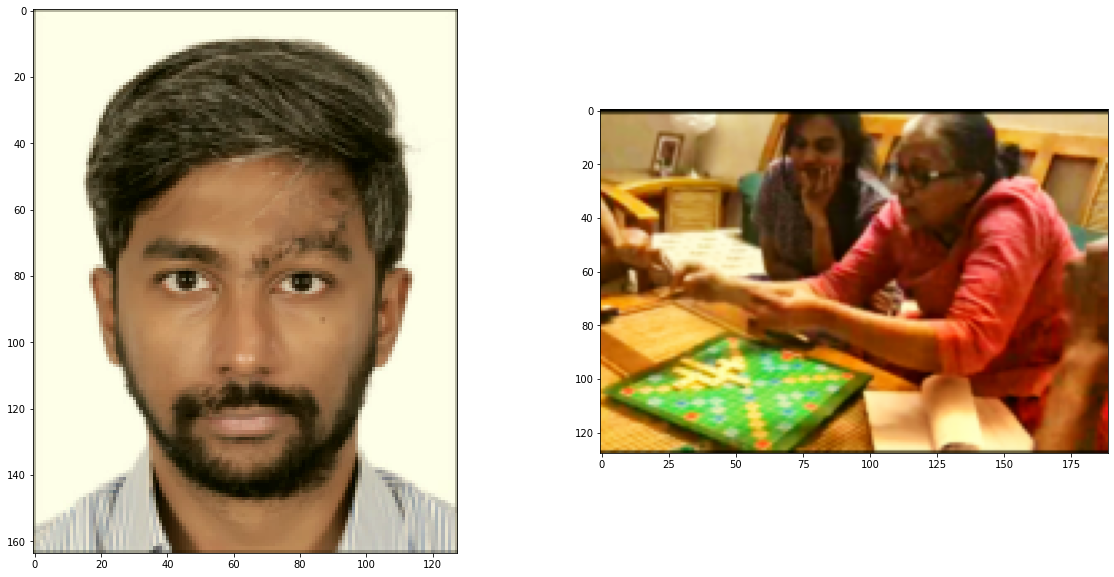

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor         
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [ ]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
print(content_features)

{'conv1_1': tensor([[[[0.0000, 0.8062, 1.2001,  ..., 1.2031, 0.9177, 0.0656],
          [0.3956, 1.6790, 2.0848,  ..., 2.0870, 1.8064, 0.6250],
          [0.3110, 1.5363, 1.9082,  ..., 1.9101, 1.6655, 0.5505],
          ...,
          [0.0097, 0.7251, 1.1314,  ..., 0.8763, 0.8879, 0.2914],
          [0.0000, 0.3557, 0.6674,  ..., 0.4803, 0.5017, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 1.7118, 3.9108,  ..., 3.9973, 5.3347, 5.0168],
          [0.0000, 0.0000, 1.6392,  ..., 1.7610, 4.3712, 6.0436],
          [0.0000, 0.0000, 0.2758,  ..., 0.3918, 3.3929, 6.2055],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8355, 0.6449, 4.7428],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.8265],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3930]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3519, 1.7272, 1.3761,  ..., 1.3608, 1.0359, 0.0000],
          [0.6297, 1.9025, 1.4

In [ ]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e3  # beta

Total loss:  11937.4931640625


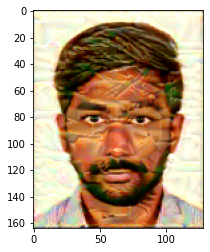

Total loss:  5513.1611328125


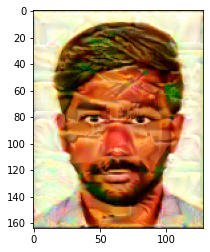

KeyboardInterrupt: ignored

In [ ]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5001  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
model1 =models.vgg19(pretrained=True)

In [ ]:
features = model1.classifier((style))


RuntimeError: ignored